In [1]:
import cv2
import matplotlib.pyplot as plt
import face_recognition
import os
import random 
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
def resize_image(image):
    img = cv2.resize(image, (100, 100))
    return img

def generate_labels(is_masked, image):
    face_location = face_recognition.face_locations(image)
    if(face_location == []): return None
    label = 1 if is_masked else 0
    return label

In [3]:
def gen_train_dataset():
    dataset = []
    count = 0
    for file in os.listdir("./Face_Mask_Dataset/Train/WithMask/"):
        image_file = os.path.join('./Face_Mask_Dataset/Train/WithMask/', file)
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_img = resize_image(image)
        normalized_img = cv2.normalize(resize_img, None, 0, 1, cv2.NORM_MINMAX)
        img_tensor = tf.convert_to_tensor(normalized_img, dtype=tf.float32)
        label = tf.constant([1,0], dtype=tf.float32)
        dataset.append([img_tensor, label])
        count=count+1
        print('Number of Images in Training Dataset:',count)

    for file in os.listdir("./Face_Mask_Dataset/Train/WithoutMask/"):
        image_file = os.path.join("./Face_Mask_Dataset/Train/WithoutMask/",file)
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_img = resize_image(image)
        normalized_img = cv2.normalize(resize_img, None, 0, 1, cv2.NORM_MINMAX)
        img_tensor = tf.convert_to_tensor(normalized_img, dtype=tf.float32)
        label = tf.constant([0,1], dtype=tf.float32)
        dataset.append([img_tensor, label])
        count=count+1
        print('Number of Images in Training Dataset:',count)

    random.shuffle(dataset)
    return dataset

def gen_validation_dataset():
    dataset = []
    count = 0
    for file in os.listdir("./Face_Mask_Dataset/Validation/WithMask/"):
        image_file = os.path.join('./Face_Mask_Dataset/Validation/WithMask/', file)
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_img = resize_image(image)
        normalized_img = cv2.normalize(resize_img, None, 0, 1, cv2.NORM_MINMAX)
        img_tensor = tf.convert_to_tensor(normalized_img, dtype=tf.float32)
        label = tf.constant([1,0], dtype=tf.float32)
        dataset.append([img_tensor, label])
        count=count+1
        print('Number of Images in Validation Dataset:',count)

    for file in os.listdir("./Face_Mask_Dataset/Validation/WithoutMask/"):
        image_file = os.path.join("./Face_Mask_Dataset/Validation/WithoutMask/",file)
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_img = resize_image(image)
        normalized_img = cv2.normalize(resize_img, None, 0, 1, cv2.NORM_MINMAX)
        img_tensor = tf.convert_to_tensor(normalized_img, dtype=tf.float32)
        label = tf.constant([0,1], dtype=tf.float32)
        dataset.append([img_tensor, label])
        count=count+1
        print('Number of Images in Validation Dataset:',count)

    random.shuffle(dataset)
    return dataset

def gen_test_dataset():
    dataset = []
    count = 0
    for file in os.listdir("./Face_Mask_Dataset/Test/WithMask/"):
        image_file = os.path.join('./Face_Mask_Dataset/Test/WithMask/', file)
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_img = resize_image(image)
        normalized_img = cv2.normalize(resize_img, None, 0, 1, cv2.NORM_MINMAX)
        img_tensor = tf.convert_to_tensor(normalized_img, dtype=tf.float32)
        label = tf.constant([1,0], dtype=tf.float32)
        dataset.append([img_tensor, label])
        count=count+1
        print('Number of Images in Testing Dataset:',count)

    for file in os.listdir("./Face_Mask_Dataset/Test/WithoutMask/"):
        image_file = os.path.join("./Face_Mask_Dataset/Test/WithoutMask/",file)
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_img = resize_image(image)
        normalized_img = cv2.normalize(resize_img, None, 0, 1, cv2.NORM_MINMAX)
        img_tensor = tf.convert_to_tensor(normalized_img, dtype=tf.float32)
        label = tf.constant([0,1], dtype=tf.float32)
        dataset.append([img_tensor, label])
        count=count+1
        print('Number of Images in Testing Dataset:',count)

    random.shuffle(dataset)
    return dataset

In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16,3, padding='same', input_shape=(100,100,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, strides=2))
    model.add(Conv2D(32,3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, strides=2))
    model.add(Conv2D(64,3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2, strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

NUM_EPOCHS = 200
BATCH_SIZE = 20
LR = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=LR)
lossFunction = tf.keras.losses.CategoricalCrossentropy()

In [5]:
def test_model_label0(model, X_test, y_test):
    y_pred = np.round(model.predict(X_test))
    fpr_0, tpr_0, threshold = roc_curve(y_test[:,0], y_pred[:,0])
    roc_auc_0 = roc_auc_score(y_test[:,0], y_pred[:,0])
    cm_0 = confusion_matrix(y_test[:,0], y_pred[:,0])
    print('Area under the curve for masked labels',roc_auc_0)
    print('Confusion Matrix for masked labels:\n', cm_0)
    print('False Positive Rate for masked label:\n', fpr_0)
    print('True Positive Rate for masked label:\n', tpr_0)

    return fpr_0, tpr_0, cm_0, roc_auc_0

def test_model_label1(model, X_test, y_test):
    y_pred = np.round(model.predict(X_test))
    fpr_1, tpr_1, threshold = roc_curve(y_test[:,1], y_pred[:,1])
    roc_auc_1 = roc_auc_score(y_test[:,1], y_pred[:,1])
    print('Area under the curve for unmasked labels',roc_auc_1)
    cm_1 = confusion_matrix(y_test[:,1], y_pred[:,1])
    print('Confusion Matrix for unmasked labels:\n', cm_1)
    print('False Positive Rate for unmasked label:\n', fpr_1)
    print('True Positive Rate for unmasked label:\n', tpr_1)

    return fpr_1, tpr_1, cm_1, roc_auc_1


In [6]:
train_dataset = gen_train_dataset()
val_dataset =  gen_validation_dataset()
test_dataset = gen_test_dataset()

X_train = np.array([data[0] for data in train_dataset])
y_train = np.array([data[1] for data in train_dataset])

X_val = np.array([data[0] for data in val_dataset])
y_val = np.array([data[1] for data in val_dataset])

X_test = np.array([data[0] for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

model = create_model()
trained_model = model.compile(optimizer=opt, loss=lossFunction, metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val,y_val))

fpr_0, tpr_0, cm_0, roc_auc_0 = test_model_label0(model, X_test, y_test)
fpr_1, tpr_1, cm_1, roc_auc_1 = test_model_label1(model, X_test, y_test)

Number of Images in Training Dataset: 1
Number of Images in Training Dataset: 2
Number of Images in Training Dataset: 3
Number of Images in Training Dataset: 4
Number of Images in Training Dataset: 5
Number of Images in Training Dataset: 6
Number of Images in Training Dataset: 7
Number of Images in Training Dataset: 8
Number of Images in Training Dataset: 9
Number of Images in Training Dataset: 10
Number of Images in Training Dataset: 11
Number of Images in Training Dataset: 12
Number of Images in Training Dataset: 13
Number of Images in Training Dataset: 14
Number of Images in Training Dataset: 15
Number of Images in Training Dataset: 16
Number of Images in Training Dataset: 17
Number of Images in Training Dataset: 18
Number of Images in Training Dataset: 19
Number of Images in Training Dataset: 20
Number of Images in Training Dataset: 21
Number of Images in Training Dataset: 22
Number of Images in Training Dataset: 23
Number of Images in Training Dataset: 24
Number of Images in Train

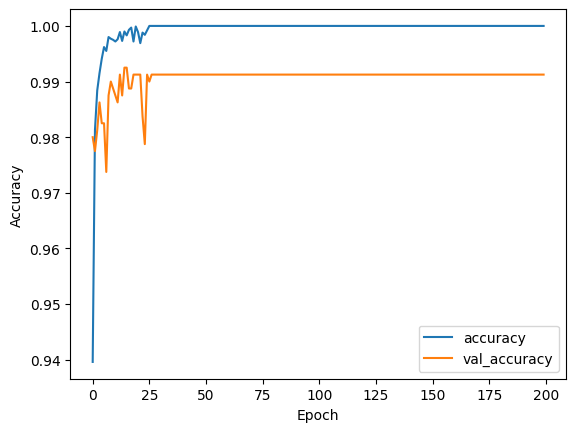

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

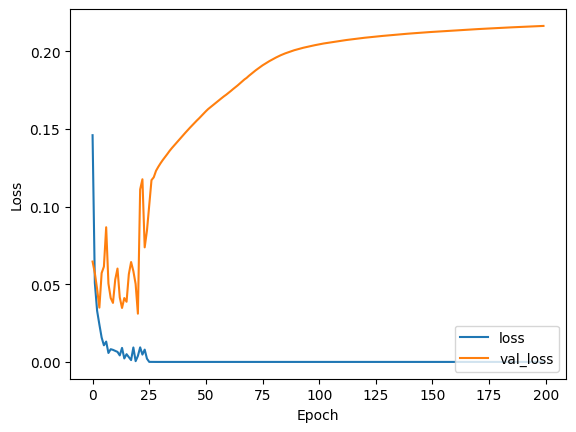

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [9]:
score = model.evaluate(X_test, y_test) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

31/31 [==============================] - 0s 4ms/step - loss: 0.3044 - accuracy: 0.9849
Test loss: 0.30439889430999756
Test accuracy: 0.9848790168762207


Result for Masked Face Prediction
Average Confusion Matrix for Masked Face Prediction:
 [[502   7]
 [  8 475]]
Average Area Under the Curve for Masked Face Prediction: 0.9848421986031962


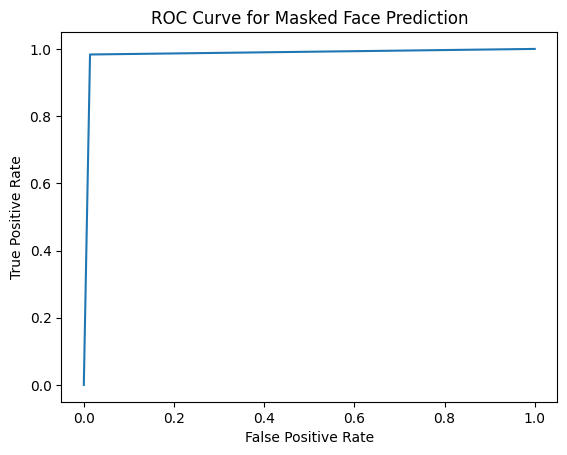

In [10]:
print('Result for Masked Face Prediction')

plt.plot(fpr_0, tpr_0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Masked Face Prediction')

print('Average Confusion Matrix for Masked Face Prediction:\n',cm_0)

print('Average Area Under the Curve for Masked Face Prediction:',roc_auc_0)

Result for Unmasked Face Prediction
Result for Masked Face Prediction
Average Confusion Matrix for Unmasked Face Prediction:
 [[475   8]
 [  7 502]]
Average Area Under the Curve for Unmasked Face Prediction: 0.9848421986031962


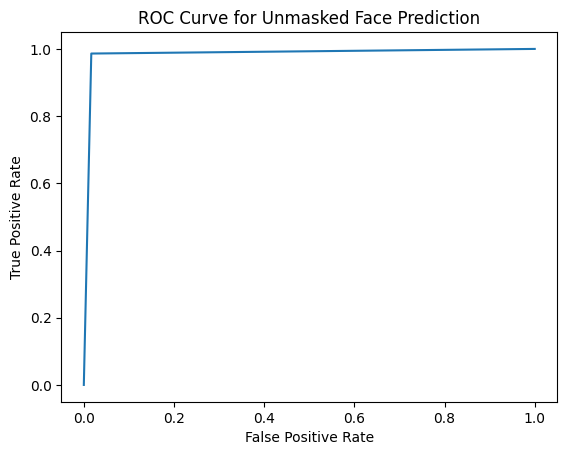

In [11]:
print('Result for Unmasked Face Prediction')

print('Result for Masked Face Prediction')

plt.plot(fpr_1, tpr_1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Unmasked Face Prediction')

print('Average Confusion Matrix for Unmasked Face Prediction:\n',cm_1)

print('Average Area Under the Curve for Unmasked Face Prediction:',roc_auc_1)

In [14]:
model.save('classifier_model')

INFO:tensorflow:Assets written to: classifier_model\assets


INFO:tensorflow:Assets written to: classifier_model\assets


In [13]:
print(X_test.shape)

(992, 100, 100, 3)
